In [1]:
%pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 23.0 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/mnemonics_benchmark')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
%pip install git+https://github.com/boudinfl/pke.git
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/boudinfl/pke.git to /tmp/pip-req-build-nxz2o0go
  Running command git clone --filter=blob:none --quiet https://github.com/boudinfl/pke.git /tmp/pip-req-build-nxz2o0go
  Resolved https://github.com/boudinfl/pke.git to commit f2d4f5d2252c64d23defccd32fdac8809cfd7ce0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 21.7 MB/s eta 0:00:00
  Created wheel for pke: filename=pke-2.0.0-py3-none-any.whl size=6160676 sha256=870898692bbb17afb31d3b8eaaeb63e47e26c823520b4847ad43357e98f43365
  Stored in directory: /tmp/pip-ephem-wheel-cache-2r5afs3u/wheels/d5/46/97/85535b5b449f70b6a3c8d1138ce8587345876891e25bfe7954
Successfully built pke
2023-04-19 14:27:32.888034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To 

In [4]:
import pke
import string
import re

stoplist = list(string.punctuation)
stoplist += pke.lang.stopwords.get('en')

def multi_partite_rank_extract(text, n):
    text = re.sub(r'<.*?>', '', text)
    multi_partite_rank = pke.unsupervised.MultipartiteRank()
    multi_partite_rank.load_document(input=text, language='en', stoplist=stoplist)
    pos = {'NOUN', 'PROPN', 'ADJ', 'VERB'}
    multi_partite_rank.candidate_selection(pos=pos)
    multi_partite_rank.candidate_weighting()
    return multi_partite_rank.get_n_best(n=n)

In [5]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [6]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
img_model = DistilBertForSequenceClassification.from_pretrained('martingrzzler/distilbert-imageability').to(device)


In [7]:
def predict(token,model):
    inputs = tokenizer(token, return_tensors='pt').to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    return logits.item()

In [8]:
import nltk
stemmer = nltk.stem.PorterStemmer()

def any_in(keyphrase, input_words):
    input_stems = set([stemmer.stem(word) for word in input_words])
    keyphrase_stems = set([stemmer.stem(word) for word in keyphrase.split()])

    return len(input_stems & keyphrase_stems) > 0 

In [9]:
keys = ['gpt2xl_mnemonic', 'gpt3_mnemonic', 'gpt3_paragraph', 'wanikani_mnemonic']

In [10]:
def map_keywords_and_scores(example):
    for key in keys:
        keywords = multi_partite_rank_extract(example[key], n=10)
        example[key + '_keywords'] = [keyword for keyword, weight in keywords]
        example[key + '_keyword_scores'] = [weight for keyword, weight in keywords]

    return example

In [11]:
ds_keywords = ds.map(map_keywords_and_scores)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [30]:
import numpy as np

def imageability_score(keywords_with_scores, input_words):
    keywords_with_scores = [(keyword, score) for keyword, score in keywords_with_scores if not any_in(keyword, input_words)]
    keywords_with_scores = keywords_with_scores[:len(input_words)]
    scores = [] 
    total_weight = 0
    for keyphrase, weight in keywords_with_scores:
        total_weight += weight
    
    for keyphrase, weight in keywords_with_scores:
        words = keyphrase.split(' ')
        score = np.mean([predict(word,img_model) for word in words])
        scores.append(score * weight / total_weight)
    
    return np.sum(scores)

In [13]:
def centrality_score(keywords_with_scores, input_words):
    total_score = 0
    for _, score in keywords_with_scores:
        total_score += score
    
    mask = [(any_in(keyphrase, input_words), score / total_score) for keyphrase, score in keywords_with_scores]

    return np.sum([score for in_input, score in mask if in_input])

In [14]:
def combined_score(keywords_with_scores, input_words):
    centrality = centrality_score(keywords_with_scores[:len(input_words)], input_words)
    imageability = imageability_score(keywords_with_scores[:len(input_words)])
    return (centrality, imageability)

In [15]:
sample = ds_keywords['train'][0]
sample_input_words = [sample['kanji_meaning']] + sample['component_meanings'].split(',')
key = keys[1]
keywords_with_scores = list(zip(sample[key + '_keywords'], sample[key + '_keyword_scores']))

In [31]:
def map_imageability(example):
    input_words = [example['kanji_meaning']] + example['component_meanings'].split(',')
    for key in keys:
        keywords_with_scores = list(zip(example[key + '_keywords'], example[key + '_keyword_scores']))
        example[key + '_imageability'] = imageability_score(keywords_with_scores, input_words)
    return example

In [32]:
ds_imageability = ds_keywords.map(map_imageability)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [16]:
def map_combined_scores(example):
    input_words = [example['kanji_meaning']] + example['component_meanings'].split(',')
    for key in keys:
        keywords_with_scores = list(zip(example[key + '_keywords'], example[key + '_keyword_scores']))
        centrality, img = combined_score(keywords_with_scores, input_words)
        example[key+'_img'] = img
        example[key+'_centrality'] = centrality
    return example

In [17]:
def map_centrality(ratio_n):
    def inner(example):
        input_words = [example['kanji_meaning']] + example['component_meanings'].split(',')
        for key in keys: 
            keywords_with_scores = list(zip(example[key + '_keywords'], example[key + '_keyword_scores']))
            upper_bound = int(len(input_words) * ratio_n)
            example[key+'_centrality'] = centrality_score(keywords_with_scores[:upper_bound], input_words)
        return example
    return inner

In [191]:
map_centrality(.5)(ds_keywords['train'][0])

{'kanji_id': 1885,
 'component_meanings': 'woman,catapult',
 'wanikani_mnemonic': "A <radical>woman</radical> loves her <radical>catapult</radical> for some good ol' fashioned <kanji>recreation</kanji>. You ask the woman what she does for fun... for recreation. She says, she goes out and shoots her catapult.",
 'kanji_meaning': 'recreation',
 'gpt2xl_mnemonic': "This is a rush transcript. Copy may not be in its final form, recreation of woman being catapulted to her death has been edited out.)\n\n\nAMY GOODMAN: We begin today's show with the shocking news that two women have died after jumping from an overpass near Los Angeles International Airport and landing on I-5 southbound just before",
 'gpt3_paragraph': 'A woman was using a catapult for recreation in her backyard. She was having a blast launching objects into the air and watching them fly. She was enjoying the peacefulness of the moment and the satisfaction of her successful shots.',
 'gpt3_mnemonic': "Once upon a time there was

In [192]:
map_combined_scores(sample)['wanikani_mnemonic_centrality']

0.7801173458037225

In [176]:
ds_scores = ds_keywords['train'].map(map_combined_scores)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [34]:
from scipy.stats import f_oneway
def anova(ds, feature):
    f, p = f_oneway(*[ds[key+'_'+feature] for key in keys])
    return f, p

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def box_plot(ds,title, feature, labels=['GPT-2','GPT-3 (mnemonic)','GPT-3 (paragraph)','WaniKani']):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.boxplot([ds[key+'_'+feature] for key in keys], labels=labels)
    plt.show()

In [36]:
from scipy.stats import tukey_hsd

def tukey(ds, feature):
    data = [ds[key+'_'+feature] for key in keys]
    res = tukey_hsd(*data)
    print(res)

In [37]:
def mean_std(ds, feature):
    return [(key, np.mean(ds[key+'_'+feature]), np.std(ds[key+'_'+feature])) for key in keys]

In [38]:
def map_weighted(centrality_weight=.5):
    def inner(example):
        for key in keys:
            example[key+'_weighted_score'] = example[key+'_centrality'] * centrality_weight + example[key+'_img'] * (1-centrality_weight)
        return example
    return inner

In [39]:
import numpy as np

def group_variance(ds, score_name):
    within_group_vars = [np.var(ds[key+'_'+score_name]) for key in keys]
    total_mean = np.mean([score for key in keys for score in ds[key+'_'+score_name]])
    between_group_var = np.sum([(np.mean(ds[key+'_'+score_name]) - total_mean) ** 2 for key in keys]) / (len(keys) - 1)
    return within_group_vars, between_group_var

In [43]:
mean_std(ds_imageability['train'], 'imageability')

[('gpt2xl_mnemonic', 0.5656726903962208, 0.09163098683267158),
 ('gpt3_mnemonic', 0.5976190201463154, 0.11198810038315164),
 ('gpt3_paragraph', 0.5813196365440207, 0.10396066777829957),
 ('wanikani_mnemonic', 0.5669264019345996, 0.12855374098996344)]

In [44]:
anova(ds_imageability['train'], 'imageability')

(3.5001187695677958, 0.01520845784426993)

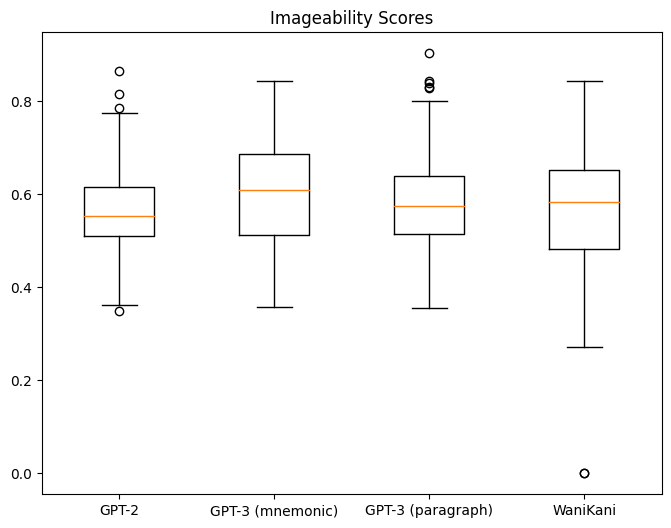

In [45]:
box_plot(ds_imageability['train'], 'Imageability Scores', 'imageability')

In [46]:
tukey(ds_imageability['train'], 'imageability')

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.032     0.025    -0.061    -0.003
 (0 - 2)     -0.016     0.509    -0.045     0.013
 (0 - 3)     -0.001     1.000    -0.030     0.028
 (1 - 0)      0.032     0.025     0.003     0.061
 (1 - 2)      0.016     0.473    -0.013     0.045
 (1 - 3)      0.031     0.034     0.002     0.060
 (2 - 0)      0.016     0.509    -0.013     0.045
 (2 - 1)     -0.016     0.473    -0.045     0.013
 (2 - 3)      0.014     0.580    -0.015     0.043
 (3 - 0)      0.001     1.000    -0.028     0.030
 (3 - 1)     -0.031     0.034    -0.060    -0.002
 (3 - 2)     -0.014     0.580    -0.043     0.015



In [214]:
n_keywords = np.linspace(1, 3, 10)
ds_centralilties = []
best_var_ratio = 0
best_n = 0
ratios = []
within_vars = []
between_vars = []

for n in n_keywords:
    ds_cent = ds_scores.map(map_centrality(n))
    ds_centralilties.append(ds_cent)
    within_group_vars, between_group_var = group_variance(ds_cent, 'centrality')
    within_vars.append(within_group_vars)
    between_vars.append(between_group_var)
    var_ratio = between_group_var / np.sum(within_group_vars)
    ratios.append(var_ratio)
    if var_ratio > best_var_ratio:
        best_var_ratio = var_ratio
        best_n = n

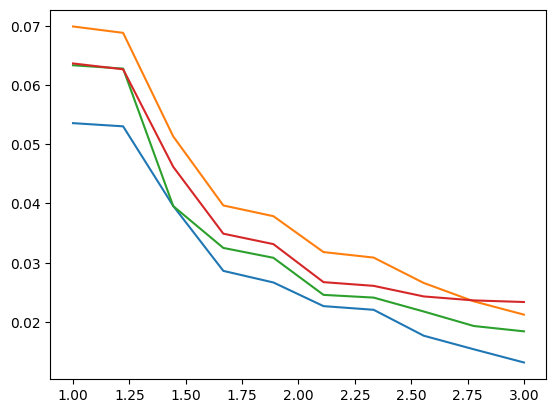

In [215]:
plt.plot(n_keywords, within_vars)

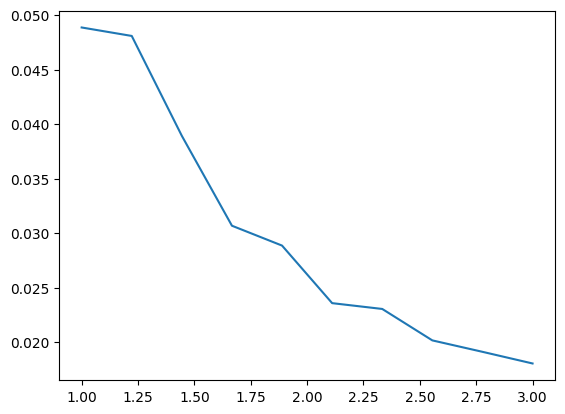

In [216]:
plt.plot(n_keywords, between_vars)

In [209]:
best_n, best_var_ratio

(1.0, 0.05488595598577161)

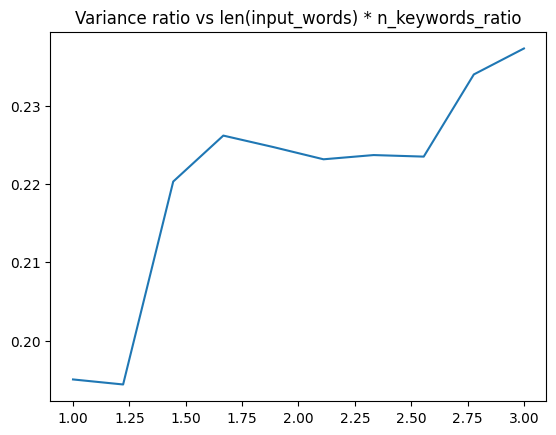

In [213]:
plt.title('Variance ratio vs len(input_words) * n_keywords_ratio')
plt.plot(n_keywords, ratios)
plt.show()

In [198]:
ds_combined = ds_scores.map(map_weighted(centrality_weight=.5))
group_variance(ds_combined, 'weighted_score')

([0.019561039690073483,
  0.02425403173850315,
  0.0242940731346398,
  0.02435753415660814],
 0.016439320388420033)

In [228]:
centrality_weights = np.linspace(0,1,11)
ds_combineds = []
best_var_ratio = 0
best_centrality_weight = 0
ratios = []
between_vars = []
within_vars = []

for centrality_weight in centrality_weights:
    ds_combined = ds_scores.map(map_weighted(centrality_weight))
    ds_combineds.append(ds_combined)
    within, between = group_variance(ds_combined, 'weighted_score')
    between_vars.append(between)
    within_vars.append(within)
    var_ratio = between / np.sum(within)
    ratios.append(var_ratio)
    if var_ratio > best_var_ratio:
        best_var_ratio = var_ratio
        best_centrality_weight = centrality_weight

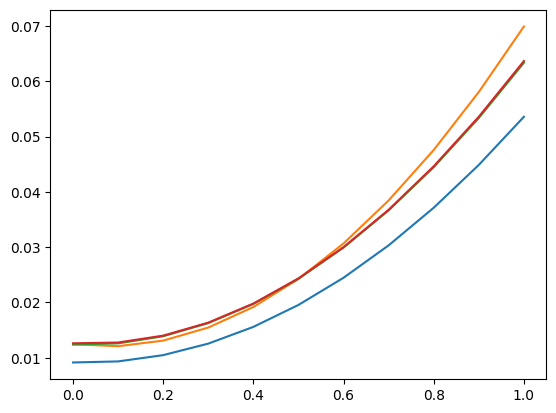

In [229]:
plt.plot(centrality_weights, within_vars)
plt.show()

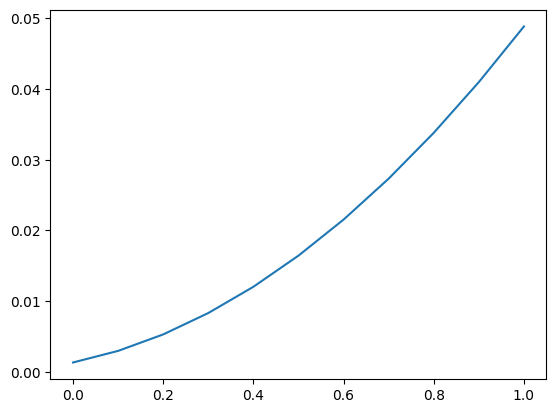

In [230]:
plt.plot(centrality_weights, between_vars)

In [219]:
print(best_centrality_weight, best_var_ratio)

0.9 0.19527230618211075


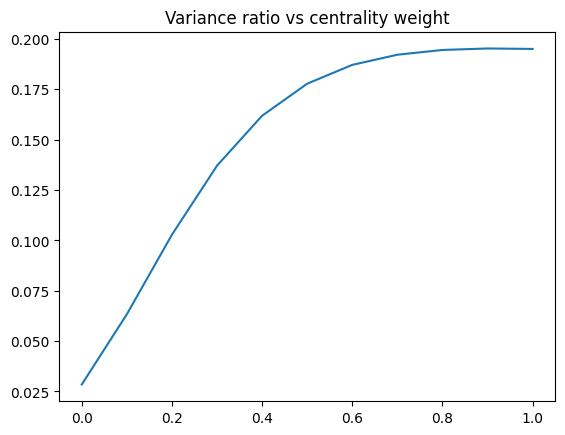

In [220]:
plt.title('Variance ratio vs centrality weight')
plt.plot(centrality_weights, ratios)
plt.show()

In [246]:
ds_final = ds_scores.map(map_weighted(.9))

In [247]:
mean_std(ds_final, 'weighted_score')

[('gpt2xl_mnemonic', 0.23193088278518922, 0.2118517887159921),
 ('gpt3_mnemonic', 0.5634341679759416, 0.24096238105114637),
 ('gpt3_paragraph', 0.4141885546136754, 0.23100421685589742),
 ('wanikani_mnemonic', 0.7039209033238236, 0.23149295284632604)]

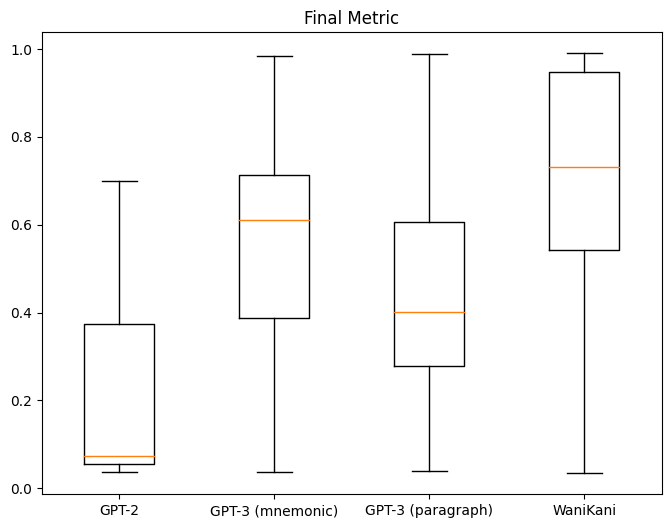

In [248]:
box_plot(ds_final, 'Final Metric', 'weighted_score')

In [249]:
print(anova(ds_final, 'weighted_score'))

(147.62586347367574, 2.6959317484307206e-75)


In [250]:
tukey(ds_final, 'weighted_score')

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.332     0.000    -0.392    -0.271
 (0 - 2)     -0.182     0.000    -0.243    -0.122
 (0 - 3)     -0.472     0.000    -0.533    -0.411
 (1 - 0)      0.332     0.000     0.271     0.392
 (1 - 2)      0.149     0.000     0.089     0.210
 (1 - 3)     -0.140     0.000    -0.201    -0.080
 (2 - 0)      0.182     0.000     0.122     0.243
 (2 - 1)     -0.149     0.000    -0.210    -0.089
 (2 - 3)     -0.290     0.000    -0.350    -0.229
 (3 - 0)      0.472     0.000     0.411     0.533
 (3 - 1)      0.140     0.000     0.080     0.201
 (3 - 2)      0.290     0.000     0.229     0.350



In [251]:
def print_mnemonic(key):
    def inner(x):
        print(x['kanji_meaning'], x['component_meanings'])
        print(x[key+'_keywords'])
        print(x[key])
        print()
    return inner

In [252]:

ds_final.to_pandas().sort_values('wanikani_mnemonic_weighted_score', ascending=False).iloc[:2].apply(print_mnemonic('wanikani_mnemonic'), axis=1)

house roof,pig
['pig' 'roof' 'house' 'live' 'nice' 'warm' 'deserves' 'picture' 'home'
 'family']
Under this <radical>roof</radical> is a <radical>pig</radical>. Your pig, because it's your <kanji>house</kanji>! You keep your pig inside where it's nice and warm. He's a member of your family, so he deserves to live in your <kanji>home</kanji> too. Picture the little pig, prancing around happily under the roof of your house.

road foot,kiss
['kiss' 'foot' 'dirt road' 'want' 'feet' 'walking' 'going'
 'imagine kissing' 'filthy' 'sweaty']
If you’ve been walking all day, nobody is going to want to <radical>kiss</radical> your <radical>foot</radical> if you’ve been walking barefoot down a dirt <kanji>road</kanji>. Your feet are filthy, sweaty, and stinky. Nobody is going to want to kiss those feet. Imagine kissing someone’s foot. Now imagine kissing someone’s foot after they’ve been walking down a dirt road for hours. It’s disgusting. Smell the stench of dirt and sweat wafting up into your nos

66    None
32    None
dtype: object

In [253]:
ds_final.to_pandas().sort_values('wanikani_mnemonic_weighted_score', ascending=True).iloc[4:6].apply(print_mnemonic('wanikani_mnemonic'), axis=1)

both ground,head,mountain
['great finds' 'found' 'strange things' 'find' 'mountain' 'head' 'things'
 'dug' 'want' 'focus']
Under the <radical>ground</radical>, which you dug into, you found two great finds. You found <kanji>both</kanji> a <radical>mountain</radical> and a <radical>head</radical>, two strange things to find underground. You'll want to focus on the part where you find <kanji>both</kanji>, not so much the things themselves. Think about how you can't believe you did so well finding both things at once. Usually you only find one or the other when you're searching.

sunlight triceratops,pi
['absorb' 'light' 'round' 'pi shaped' 'shadow' 'imagine' 'evolved' 'want'
 'natural' 'sun']
You see a <radical>triceratops</radical> in the distance. But, it's odd. It's perfectly <radical>pi</radical> shaped (that is, circular). Some kind of piceratops, if you will. The reason they are this shape is because they want to absorb as much <kanji>sunlight</kanji> (or just <kanji>light</kanji> 

147    None
122    None
dtype: object

In [254]:
ds_final.to_pandas().sort_values('gpt2xl_mnemonic_weighted_score', ascending=False).iloc[:2].apply(print_mnemonic('gpt2xl_mnemonic'), axis=1)

throw up mouth,dirt
['little mouthful' 'dirt' 'college educations' 'kids' 'think' 'comes'
 'mind' 'throw' 'important things going' 'world']
I throw up a little mouthful of dirt when I think about it. It's the first thing that comes to my mind, even though there are so many more important things going on in this world than whether or not we've got enough money for our kids' college educations (which is an entirely separate issue). But if you ask me

genius leader,spider
['spider genius' 'leader' 'free world' 'final form' 'amy goodman'
 'happened' 'begin today' 'copy' 'osama' 'rush transcript']
This is a rush transcript. Copy may not be in its final form, spider genius or leader of the free world!


AMY GOODMAN: We begin today's show with an explosive new exposé by Pulitzer Prize-winning investigative journalist Seymour Hersh detailing how President Obama and his top national security officials have repeatedly lied about what happened to Osama



53     None
146    None
dtype: object

In [255]:
ds_final.to_pandas().sort_values('gpt3_mnemonic_weighted_score', ascending=False).iloc[:2].apply(print_mnemonic('gpt3_mnemonic'), axis=1)

willow tree,stamp
['willow tree' 'curious stamp collector' 'tree' 'admire' 'reminder'
 'walking' 'day' 'meadow' 'noticed' 'stopped']
Once upon a time, there was a willow tree in a meadow. One day, a curious stamp collector was walking by and noticed the tree. He stopped to admire the tree and marveled at its beauty. He decided to take a stamp from his collection and place it on the tree as a reminder of the moment. The willow tree will forever serve as a reminder of the stamp collector's admiration.

boisterous mouth,mask
['mask' 'boisterous young man' 'mouth' 'wore' 'loud' 'energetic' 'got'
 'trouble' 'day' 'boisterous']
Once upon a time, there was a boisterous young man who always wore a mask over his mouth. He was always so loud and energetic, and he was always getting himself into trouble. One day, he got so boisterous that his mask flew off and people were shocked at what was underneath. He had a big mouth full of sharp teeth and everyone ran away in fear! From then on, he was car

67    None
69    None
dtype: object

In [256]:
ds_final.to_pandas().sort_values('gpt3_mnemonic_weighted_score', ascending=True).iloc[:2].apply(print_mnemonic('gpt3_mnemonic'), axis=1)

axis car,reason
['tried' 'way' 'wrong turn' 'remember' 'car' 'driving' 'taken' 'realize'
 'wrong axis' 'found']
Once upon a time, there was a man named Reason who was driving his car down the highway. He was so focused on the road ahead that he didn't realize he had taken a wrong turn and was now on the wrong axis. He tried to turn around but it was too late, and he was now hopelessly lost. He tried to remember the way he had come, but all he could remember was the car he was driving. He eventually found his way back, but it was a lesson he would never forget: always pay attention to where you're going, or you may end up

trust bundle,geoduck
['start' 'wanted' 'open' 'business' 'hard work' 'determined' 'succeed'
 'successful shop' 'trusted' 'geoduck']
Once upon a time there was a geoduck who wanted to start a business. He was determined to succeed, so he bundled all of his resources together and trusted that his hard work would pay off. He was eventually able to open a successful shop 

180    None
12     None
dtype: object

In [257]:
ds_final.to_pandas().sort_values('gpt3_paragraph_weighted_score', ascending=False).iloc[:2].apply(print_mnemonic('gpt3_paragraph'), axis=1)

boulder mountain,stone
['mountain' 'boulders' 'stones' 'covered' 'shapes' 'sizes'
 'beautiful sight' 'behold' 'large' 'majestic']
The mountain was covered in stones and boulders of all shapes and sizes. Some of the boulders were so large that they seemed to be a part of the mountain itself. It was a beautiful sight to behold, and it made the mountain look even more majestic.

carp fish,village
['small village' 'carp' 'fish' 'famous' 'abundance' 'villagers' 'morning'
 'generation' 'lake' 'catch carp']
The small village was famous for its abundance of fish, particularly carp. Every morning, the villagers would go out to the lake and catch carp for their breakfast. It was a tradition that had been passed down from generation to generation, and the villagers were proud of their fishing heritage.



115    None
174    None
dtype: object

In [258]:
ds_final.to_pandas().sort_values('gpt3_paragraph_weighted_score', ascending=True).iloc[:2].apply(print_mnemonic('gpt3_paragraph'), axis=1)

past dirt,private
['think' 'like' 'try' 'hard' 'buried' 'forget' 'sight' 'private past'
 'dirt']
The dirt of my private past is something I don't like to think about. I try to keep it buried and out of sight, but sometimes it is hard to forget.

poison life,window
['let' 'opened' 'light' 'poison' 'choose' 'comes' 'window' 'life' 'react']
Life is like a window, it can be opened to let in light, or it can be opened to let in poison. It is up to us to choose what comes in, and how we react to it.



47     None
178    None
dtype: object